In [31]:
import numpy as np
import random
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"    

In [3]:
dir_model="./results/Env2"
if not os.path.exists(dir_model):
    os.makedirs(dir_model)

In [4]:
data='wav44.npz'
nFolds = 5
n_classes = 50
n_splits = 1
input_length = 66650
crop_size = 10

# Dataset preparation

Splitting the dataset into train & validation set

In [5]:
def one_hot_encoding(labels):
    b = np.zeros((len(labels), n_classes))
    b[np.arange(len(labels)), labels] = 1
    return b

In [6]:
def setup(split):
    dataset = np.load(os.path.join('.',data))
    # Split to train and val
    train_sounds = []
    train_labels = []
    val_sounds = []
    val_labels = []
    for i in range(1, nFolds + 1):
        sounds = dataset['fold{}'.format(i)].item()['sounds']
        labels = dataset['fold{}'.format(i)].item()['labels']
        if i == split:
            val_sounds.extend(sounds)
            val_labels.extend(labels)
        else:
            train_sounds.extend(sounds)
            train_labels.extend(labels)
                  
    train_labels= one_hot_encoding(train_labels)
    val_labels= one_hot_encoding(val_labels)
    
    return train_sounds,train_labels, val_sounds,val_labels

Normalize to have value between -1 and 1

In [7]:
def normalize(sound, factor=32768):
    return [s/factor for s in sound]

Random crop of the sound values to have T-s window of sound

In [8]:
def random_crop(sound, size=input_length):
    cropped_sound=[]
    for s in sound:
        org_size = len(s)
        start = random.randint(0, org_size - size)
        cropped_s=s[start: start + size]
        cropped_sound.append(cropped_s)
    return cropped_sound

In [9]:
def padding(sound, pad=input_length//2):
    padded_sound=[]
    for i in range(len(sound)):
        padded_s=np.pad(sound[i], pad, 'constant')
        padded_sound.append(padded_s)
    return padded_sound

Multi-crop for testing phase

In [10]:
def multi_crop(sounds,input_length=input_length, n_crops=crop_size):
    multi_cropped_sounds=[]
    for s in sounds:
        stride = (len(s) - input_length) // (n_crops - 1)
        multi_cropped_sound = [s[stride * i: stride * i + input_length] for i in range(n_crops)]
        multi_cropped_sounds.append(np.array(multi_cropped_sound))
    return multi_cropped_sounds

In [11]:
def random_scale(sounds,max_scale=1.25, interpolate='Linear'):
    sounds_augmented=[]
    for s in sounds:
        scale = np.power(max_scale, random.uniform(-1, 1))
        output_size = int(len(s) * scale)
        ref = np.arange(output_size) / scale
        if interpolate == 'Linear':
            ref1 = ref.astype(np.int32)
            ref2 = np.minimum(ref1 + 1, len(s) - 1)
            r = ref - ref1
            scaled_sound = s[ref1] * (1 - r) + s[ref2] * r
        elif interpolate == 'Nearest':
            scaled_sound = s[ref.astype(np.int32)]
        else:
            raise Exception('Invalid interpolation mode {}'.format(interpolate))

        sounds_augmented.append(scaled_sound)
    return sounds_augmented

# Model

## Input of the model

Recall that the tensor is 4D : [batch, height, width, channel]

In [12]:
tf.reset_default_graph()

In [13]:
X = tf.placeholder(tf.float32, shape=[None, 66650,1, 1])
y = tf.placeholder(tf.float32, shape=[None, n_classes])

In [14]:
keep_prob = tf.placeholder(tf.float32) # 50%

In [15]:
is_training = tf.placeholder(tf.bool)

## Hyperparameters

In [16]:
training_epoch = 1000 
batch_size = 64
max_nepoch_no_imprv = 7
early_stopping = False
learning_rate = tf.placeholder(tf.float32)

Lr decay

In [17]:
def lr(epoch):
    if (0<=epoch<=300):
        return 0.01
    if (300<epoch<=600):
        return 0.001
    if (600<epoch):
        return 0.0001
    else: return 0.00001

Stride =1

No Padding

In [18]:
def conv2d(x, W, b,is_training, s_h=1, s_w=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, s_h, s_w, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    x = tf.contrib.layers.batch_norm(x, is_training=is_training)
    return tf.nn.relu(x) 

def maxpool2d(x, k_h=2, k_w=2): #non-overlapping max-pooling
    return tf.nn.max_pool(x, ksize=[1, k_h, k_w, 1], strides=[1, k_h, k_w, 1],padding='VALID')

## Parameters of the model

Initialization of the parameters = He initialization

Review the order (does the order actually matters ?)

[heigth_filter, width_filter, depth_filter, number of filters]

In [19]:
weights = {
    #conv1
    'wc1': tf.get_variable('W0', shape=(64,1,1,32), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    #conv2
    'wc2': tf.get_variable('W1', shape=(16,1,32,64), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    #conv3
    'wc3': tf.get_variable('W2', shape=(8,8,1,32), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    #conv4
    'wc4': tf.get_variable('W3', shape=(8,8,32,32), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    #conv5
    'wc5': tf.get_variable('W4', shape=(4,1,32,64), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    #conv6
    'wc6': tf.get_variable('W5', shape=(4,1,64,64), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    #conv7
    'wc7': tf.get_variable('W6', shape=(2,1,64,128), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    #conv8
    'wc8': tf.get_variable('W7', shape=(2,1,128,128), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    #conv9
    'wc9': tf.get_variable('W8', shape=(2,1,128,256), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    #conv10
    'wc10': tf.get_variable('W9', shape=(2,1,256,256), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    
    
    
    
    #fc11
    'wfc11': tf.get_variable('W10', shape=(256*8*10,4096), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    #fc12
    'wfc12': tf.get_variable('W11', shape=(4096,4096), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    #output
    'out': tf.get_variable('W12', shape=(4096,n_classes), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)), 
}
biases = {
    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    'bc3': tf.get_variable('B2', shape=(32), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    'bc4': tf.get_variable('B3', shape=(32), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    'bc5': tf.get_variable('B4', shape=(64), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    'bc6': tf.get_variable('B5', shape=(64), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    'bc7': tf.get_variable('B6', shape=(128), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    'bc8': tf.get_variable('B7', shape=(128), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    'bc9': tf.get_variable('B8', shape=(256), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    'bc10': tf.get_variable('B9', shape=(256), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    
    'bfc11': tf.get_variable('B10', shape=(4096), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    'bfc12': tf.get_variable('B11', shape=(4096), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
    'out': tf.get_variable('B12', shape=(n_classes), initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float32)),
}

## EnvNet

In [20]:
def env_net(x, weights, biases):  

    conv1 = conv2d(x, weights['wc1'], biases['bc1'], is_training,s_h=2, s_w=1)
    
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'], is_training,s_h=2, s_w=1)
    pool2 = maxpool2d(conv2, k_h=64, k_w=1)
    print(tf.shape(pool2))
    
    pool2=tf.reshape(pool2, [-1, 260, 64, 1])
    
    conv3 = conv2d(pool2, weights['wc3'], biases['bc3'], is_training)
    conv4 = conv2d(conv3, weights['wc4'], biases['bc4'], is_training)
    pool4 = maxpool2d(conv4, k_h=3, k_w=5)
    
    conv5 = conv2d(pool4, weights['wc5'], biases['bc5'], is_training)
    conv6 = conv2d(conv5, weights['wc6'], biases['bc6'], is_training)
    pool6 = maxpool2d(conv6, k_h=2, k_w=1)
    
    conv7 = conv2d(pool6, weights['wc7'], biases['bc7'], is_training)
    conv8 = conv2d(conv7, weights['wc8'], biases['bc8'], is_training)
    pool8 = maxpool2d(conv8, k_h=2, k_w=1)
    
    conv9 = conv2d(pool8, weights['wc9'], biases['bc9'], is_training)
    conv10 = conv2d(conv9, weights['wc10'], biases['bc10'], is_training)
    pool10 = maxpool2d(conv10, k_h=2, k_w=1)
    
    # Fully connected layer
    fc11 = tf.reshape(pool10, [-1, weights['wfc11'].get_shape().as_list()[0]])
    fc11 = tf.add(tf.matmul(fc11, weights['wfc11']), biases['bfc11'])
    fc11 = tf.nn.relu(fc11)
    # Drop out
    drop_out_fc11 = tf.nn.dropout(fc11, keep_prob)
    
    fc12 = tf.add(tf.matmul(drop_out_fc11, weights['wfc12']), biases['bfc12'])
    fc12 = tf.nn.relu(fc12)
    drop_out_fc12 = tf.nn.dropout(fc12, keep_prob)
    # Output, class prediction
    # finally we multiply the fully connected layer with the weights and add a bias term. 
    out = tf.add(tf.matmul(drop_out_fc12, weights['out']), biases['out'])
    return out

## Loss & optimizer of the model

In [21]:
init_momentum = 0.9
momentum = tf.Variable(init_momentum, trainable=False)

In [22]:
#beta=5e-4 

logits = env_net(X, weights, biases)
pred_train=logits

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred_train, labels=y))

# regularizers = tf.nn.l2_loss(weights['wc1']) + tf.nn.l2_loss(weights['wc2']) + \
#                 tf.nn.l2_loss(weights['wc3']) + tf.nn.l2_loss(weights['wc4']) + \
#                 tf.nn.l2_loss(weights['wfc5']) + tf.nn.l2_loss(weights['wfc6']) + \
#                 tf.nn.l2_loss(weights['out'])

# cost = tf.reduce_mean(cost + beta * regularizers)

pred_test=tf.reduce_sum(tf.nn.softmax(logits),0)

with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9, use_nesterov=True).minimize(cost)

Tensor("Shape:0", shape=(4,), dtype=int32)


In [23]:
#Here you check whether the index of the maximum value of the predicted image is equal to the actual labelled image. and both will be a column vector.
#correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

correct_prediction_train = tf.equal(tf.argmax(pred_train, 1), tf.argmax(y, 1))
correct_prediction_test = tf.equal(tf.argmax(pred_test, 0), tf.argmax(y, 1)[0])

#calculate accuracy across all the given images and average them out. 
accuracy_train = tf.reduce_mean(tf.cast(correct_prediction_train, tf.float32))
accuracy_test=tf.cast(correct_prediction_test, tf.float32)

In [24]:
def save_session(sess,saver,dir_model="./results",filename="ESC_26"):
    if not os.path.exists(dir_model):
        os.makedirs(dir_model)
    saver.save(sess, os.path.join(dir_model,filename))

In [25]:
# Initializing the variables
init = tf.global_variables_initializer()

Integrate the version of Perla

In [26]:
def train(split,train_loss,train_accuracy,test_loss,test_accuracy):
    train_sounds,train_y, val_sounds,val_labels=setup(split)
    test_X=multi_crop(normalize(padding(val_sounds)))
    test_X = np.reshape(test_X, (-1, input_length, 1, 1))
    test_y=np.repeat(val_labels, 10, axis=0)
    best_score = 0
    for i in range(training_epoch):
        train_X=random_crop(normalize(padding(random_scale(train_sounds))))  # Choosing randomly a 1.5s section
        train_X = np.reshape(train_X, (-1, input_length, 1, 1)) # Reshape to have 1D input
        for batch in range(len(train_X)//batch_size):
            batch_x = train_X[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
            batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))]    
                # Run optimization op (backprop).
                    # Calculate batch loss and accuracy
            opt = sess.run(optimizer, feed_dict={X: batch_x, y: batch_y, 
                                                     keep_prob:0.5, is_training:True, 
                                                     learning_rate:lr(i)})
            loss, acc = sess.run([cost, accuracy_train], feed_dict={X: batch_x, y: batch_y, 
                                                                     keep_prob:0.5, is_training:True,
                                                                 learning_rate:lr(i)})

        acc_test=[]
        for crop in range(len(test_X)//crop_size):
            crop_x = test_X[crop*crop_size:min((crop+1)*crop_size,len(test_X))]
            crop_y = test_y[crop*crop_size:min((crop+1)*crop_size,len(test_y))] 

            acc_t= sess.run([accuracy_test], feed_dict={X: crop_x, y : crop_y, 
                                                                       keep_prob:1.0, is_training:False,
                                                        learning_rate:lr(i)})
            acc_test.append(acc_t)

        test_acc=np.mean(acc_test)
        #print(len(acc_test))

        train_loss.append(loss)
        #test_loss.append(valid_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        if i % 10 == 0:
            print('| Epoch: {}/{} | Train: LR {}  Loss {:.6f} Training Accuracy : {:.3f} Testing Accuracy: {:.2f}\n'.format(
                        i, training_epoch, lr(i), train_loss[i],train_accuracy[i],test_accuracy[i]))
        # early stopping and saving best parameters
        if early_stopping :
            if test_acc > best_score:
                nepoch_no_imprv = 0
                save_session(sess,saver,dir_model,filename="Env2")
                best_score = test_acc
            elif test_acc == best_score:
                nepoch_no_imprv += 1
                if nepoch_no_imprv >= max_nepoch_no_imprv:
                    print("- early stopping {} epochs without "\
                          "improvement".format(nepoch_no_imprv))
                    break
        else :
            save_session(sess,saver,dir_model,filename="Env2")

In [27]:
saver = tf.train.Saver(tf.global_variables())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(init) 
    train_loss = [ [] for i in range(n_splits) ]
    train_accuracy = [ [] for i in range(n_splits) ]
    test_loss = [ [] for i in range(n_splits) ]
    test_accuracy = [ [] for i in range(n_splits) ]
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for split in range(1,n_splits+1):
        print('+-- Split {} --+'.format(split))
        train(split,train_loss[split-1],train_accuracy[split-1],test_loss[split-1],test_accuracy[split-1])            
    summary_writer.close()

+-- Split 1 --+
| Epoch: 0/1000 | Train: LR 0.01  Loss 3.941177 Training Accuracy : 0.016 Testing Accuracy: 0.02

| Epoch: 10/1000 | Train: LR 0.01  Loss 3.622289 Training Accuracy : 0.078 Testing Accuracy: 0.02

| Epoch: 20/1000 | Train: LR 0.01  Loss 3.242480 Training Accuracy : 0.125 Testing Accuracy: 0.02

| Epoch: 30/1000 | Train: LR 0.01  Loss 2.675236 Training Accuracy : 0.203 Testing Accuracy: 0.04

| Epoch: 40/1000 | Train: LR 0.01  Loss 2.561564 Training Accuracy : 0.281 Testing Accuracy: 0.03

| Epoch: 50/1000 | Train: LR 0.01  Loss 2.306232 Training Accuracy : 0.359 Testing Accuracy: 0.02

| Epoch: 60/1000 | Train: LR 0.01  Loss 2.269465 Training Accuracy : 0.359 Testing Accuracy: 0.03

| Epoch: 70/1000 | Train: LR 0.01  Loss 1.887403 Training Accuracy : 0.438 Testing Accuracy: 0.03

| Epoch: 80/1000 | Train: LR 0.01  Loss 1.653054 Training Accuracy : 0.469 Testing Accuracy: 0.03

| Epoch: 90/1000 | Train: LR 0.01  Loss 1.751841 Training Accuracy : 0.438 Testing Accuracy: 0

KeyboardInterrupt: 

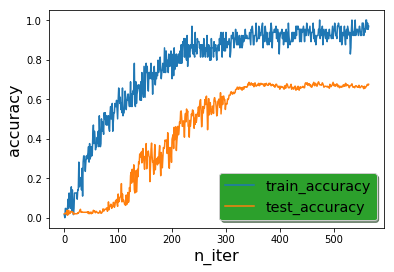

In [35]:
fig, ax = plt.subplots()
ax.plot(train_accuracy[0],label='train_accuracy')
ax.plot(test_accuracy[0],label='test_accuracy')
plt.xlabel('n_iter', fontsize=16)
plt.ylabel('accuracy', fontsize=16)
legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C2')
plt.savefig(os.path.join(dir_model,"evol_accuracy"))

In [ ]:
tf.reset_default_graph()

Version with mean

In [36]:
# def train(split,train_loss,train_accuracy,test_loss,test_accuracy):
#     train_sounds,train_y, val_sounds,test_y=setup(split)
#     for i in range(training_epoch):
#         train_X=random_crop(normalize(padding(random_scale(train_sounds)))) # Choosing randomly a 1.5s section
#         train_X = np.reshape(train_X, (-1, 24014, 1, 1)) # Reshape to have 1D input
#         test_X=random_crop(normalize(padding(val_sounds)))
#         test_X = np.reshape(test_X, (-1, 24014, 1, 1))
#         loss_by_epoch=0
#         acc_by_epoch=0
#         for batch in range(len(train_X)//batch_size):
#             batch_x = train_X[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
#             batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))]    
#             # Run optimization op (backprop).
#             # Calculate batch loss and accuracy
#             opt = sess.run(optimizer, feed_dict={X: batch_x, y: batch_y, 
#                                                      keep_prob:0.5, is_training:True, 
#                                                      learning_rate:lr(i)})
#             loss, acc = sess.run([cost, accuracy], feed_dict={X: batch_x, y: batch_y, 
#                                                                      keep_prob:0.5, is_training:True,
#                                                                  learning_rate:lr(i)})
#             loss_by_epoch+=loss*len(batch_y)
#             acc_by_epoch+=acc*len(batch_y)
#         loss_by_epoch/= len(train_y)
#         train_loss.append(loss_by_epoch)
        
#         acc_by_epoch = 100 * (acc_by_epoch / len(train_y))
#         train_accuracy.append(acc_by_epoch)
        
#         loss_acc,test_acc = sess.run([cost,accuracy], feed_dict={X: test_X, y : test_y, 
#                                                                         keep_prob:1.0, is_training:False,
#                                                                         learning_rate:lr(i)})
#         test_accuracy.append(test_acc*100)
#         test_loss.append(loss_acc*100)
#         if i % 10 == 0 or i == training_epoch-1:
#             print('| Epoch: {}/{} | Train: LR {}  Loss {:.6f} Training Accuracy : {:.3f} Testing Accuracy: {:.2f}\n'.format(
#                         i+1, training_epoch, lr(i), train_loss[i],train_accuracy[i],test_accuracy[i]))

Cross-validation

In [37]:
# with tf.device("/gpu:1"):
#     with tf.Session() as sess:
#         sess.run(init) 
#         train_loss = [ [] for i in range(nFolds) ]
#         train_accuracy = [ [] for i in range(nFolds) ]
#         test_accuracy = [ [] for i in range(nFolds) ]
#         summary_writer = tf.summary.FileWriter('./Output', sess.graph)
#         for split in range(1,nFolds+1):
#             print('+-- Split {} --+'.format(split))
#             train(split,train_loss[split-1],train_accuracy[split-1],test_accuracy[split-1])            
#         summary_writer.close()

TO DO : 
- looks like it's overfitting (check if drop out is working)
- look if there is a bug somewhere
- look padding function ? what is the use ?
- maybe a problem with the testing phase ? what is multi_crop function ?
- Accuracy for now : 0.2950 (with my dataset), 0.35750 (with their dataset)
- why is training accuracy low ?
- check for silent windows -> remove them